In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from finta import TA

In [2]:
import alpaca_trade_api as tradeapi
alpaca_api_key = 'PKXUNEDZ7VLE1EYMR65D'
alpaca_secret_key = '9o20jTOiT6jwikAbN2gNTrtku09lqm8bX02k2WBs'
alpaca_api_base_url = "https://paper-api.alpaca.markets"
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)
# Set the ticker
ticker = "SPY"
# Set timeframe to "1Day"
timeframe = "1Day"
# Set start and end datetimes of 5 years
start_date = pd.Timestamp("2019-01-02", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-01-02", tz="America/New_York").isoformat()
# Get 5 years worth of historical data for SPY
ticker_data = api.get_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date
).df


In [3]:
ticker_data.head()

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2019-01-02 05:00:00+00:00,250.23,251.21,245.95,603603,245.98,132165224,249.138858
2019-01-03 05:00:00+00:00,244.15,248.57,243.67,698036,248.23,146823673,245.630167
2019-01-04 05:00:00+00:00,252.39,253.11,247.17,708230,247.59,145055352,250.484620
2019-01-07 05:00:00+00:00,254.29,255.95,251.69,449993,252.69,105208591,254.071648
2019-01-08 05:00:00+00:00,256.62,257.31,254.00,461969,256.82,103624383,255.859713


In [4]:
signals_df= ticker_data.loc[:,['open','high','low','close']]
signals_df['Actual Returns']= signals_df['close'].pct_change()
signals_df=signals_df.dropna()
signals_df.head()

                                
                                

,open,high,low,close,Actual Returns
timestamp,,,,,
2019-01-03 05:00:00+00:00,248.23,248.57,243.67,244.15,-0.024298
2019-01-04 05:00:00+00:00,247.59,253.11,247.17,252.39,0.033750
2019-01-07 05:00:00+00:00,252.69,255.95,251.69,254.29,0.007528
2019-01-08 05:00:00+00:00,256.82,257.31,254.00,256.62,0.009163
2019-01-09 05:00:00+00:00,257.56,258.91,256.19,257.92,0.005066


## Generating Trading Signals

In [5]:
short_window = 20
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['TEMA_Fast'] = TA.TEMA(signals_df, short_window)
signals_df['TEMA_Slow'] = TA.TEMA(signals_df, short_window)

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,open,high,low,close,Actual Returns,TEMA_Fast,TEMA_Slow
timestamp,,,,,,,
2019-01-03 05:00:00+00:00,248.23,248.57,243.67,244.15,-0.024298,244.150000,244.150000
2019-01-04 05:00:00+00:00,247.59,253.11,247.17,252.39,0.033750,251.506904,251.506904
2019-01-07 05:00:00+00:00,252.69,255.95,251.69,254.29,0.007528,254.257219,254.257219
2019-01-08 05:00:00+00:00,256.82,257.31,254.00,256.62,0.009163,256.506567,256.506567
2019-01-09 05:00:00+00:00,257.56,258.91,256.19,257.92,0.005066,258.073541,258.073541


,open,high,low,close,Actual Returns,TEMA_Fast,TEMA_Slow
timestamp,,,,,,,
2021-12-27 05:00:00+00:00,472.06,477.31,472.01,477.26,0.014152,468.250605,468.250605
2021-12-28 05:00:00+00:00,477.72,478.81,476.06,476.87,-0.000817,470.708058,470.708058
2021-12-29 05:00:00+00:00,476.98,478.56,475.92,477.48,0.001279,472.849365,472.849365
2021-12-30 05:00:00+00:00,477.93,479.00,475.67,476.16,-0.002765,474.220922,474.220922
2021-12-31 05:00:00+00:00,475.64,476.86,474.67,474.96,-0.002520,474.986587,474.986587


In [6]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,open,high,low,close,Actual Returns,TEMA_Fast,TEMA_Slow,Signal
timestamp,,,,,,,,
2019-01-03 05:00:00+00:00,248.23,248.57,243.67,244.15,-0.024298,244.150000,244.150000,-1.0
2019-01-04 05:00:00+00:00,247.59,253.11,247.17,252.39,0.033750,251.506904,251.506904,1.0
2019-01-07 05:00:00+00:00,252.69,255.95,251.69,254.29,0.007528,254.257219,254.257219,1.0
2019-01-08 05:00:00+00:00,256.82,257.31,254.00,256.62,0.009163,256.506567,256.506567,1.0
2019-01-09 05:00:00+00:00,257.56,258.91,256.19,257.92,0.005066,258.073541,258.073541,1.0


,open,high,low,close,Actual Returns,TEMA_Fast,TEMA_Slow,Signal
timestamp,,,,,,,,
2021-12-27 05:00:00+00:00,472.06,477.31,472.01,477.26,0.014152,468.250605,468.250605,1.0
2021-12-28 05:00:00+00:00,477.72,478.81,476.06,476.87,-0.000817,470.708058,470.708058,-1.0
2021-12-29 05:00:00+00:00,476.98,478.56,475.92,477.48,0.001279,472.849365,472.849365,1.0
2021-12-30 05:00:00+00:00,477.93,479.00,475.67,476.16,-0.002765,474.220922,474.220922,-1.0
2021-12-31 05:00:00+00:00,475.64,476.86,474.67,474.96,-0.002520,474.986587,474.986587,-1.0


In [7]:
signals_df['Signal'].value_counts()

Signal
 1.0    438
-1.0    318
Name: count, dtype: int64

In [8]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,open,high,low,close,Actual Returns,TEMA_Fast,TEMA_Slow,Signal,Strategy Returns
timestamp,,,,,,,,,
2019-01-03 05:00:00+00:00,248.23,248.57,243.67,244.15,-0.024298,244.150000,244.150000,-1.0,NaN
2019-01-04 05:00:00+00:00,247.59,253.11,247.17,252.39,0.033750,251.506904,251.506904,1.0,-0.033750
2019-01-07 05:00:00+00:00,252.69,255.95,251.69,254.29,0.007528,254.257219,254.257219,1.0,0.007528
2019-01-08 05:00:00+00:00,256.82,257.31,254.00,256.62,0.009163,256.506567,256.506567,1.0,0.009163
2019-01-09 05:00:00+00:00,257.56,258.91,256.19,257.92,0.005066,258.073541,258.073541,1.0,0.005066


,open,high,low,close,Actual Returns,TEMA_Fast,TEMA_Slow,Signal,Strategy Returns
timestamp,,,,,,,,,
2021-12-27 05:00:00+00:00,472.06,477.31,472.01,477.26,0.014152,468.250605,468.250605,1.0,0.014152
2021-12-28 05:00:00+00:00,477.72,478.81,476.06,476.87,-0.000817,470.708058,470.708058,-1.0,-0.000817
2021-12-29 05:00:00+00:00,476.98,478.56,475.92,477.48,0.001279,472.849365,472.849365,1.0,-0.001279
2021-12-30 05:00:00+00:00,477.93,479.00,475.67,476.16,-0.002765,474.220922,474.220922,-1.0,-0.002765
2021-12-31 05:00:00+00:00,475.64,476.86,474.67,474.96,-0.002520,474.986587,474.986587,-1.0,0.002520


<Axes: xlabel='timestamp'>

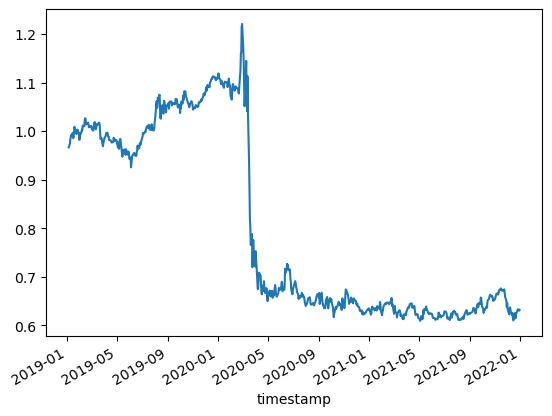

In [9]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

# Applying Machine Learning Algorithms

## Prepating the data for Training and Testing

In [10]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['TEMA_Fast', 'TEMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,TEMA_Fast,TEMA_Slow
timestamp,,
2019-01-04 05:00:00+00:00,244.150000,244.150000
2019-01-07 05:00:00+00:00,251.506904,251.506904
2019-01-08 05:00:00+00:00,254.257219,254.257219
2019-01-09 05:00:00+00:00,256.506567,256.506567
2019-01-10 05:00:00+00:00,258.073541,258.073541


In [11]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

Signal
 1.0    438
-1.0    318
Name: count, dtype: int64

In [12]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2019-01-04 05:00:00+00:00


In [13]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2019-04-04 05:00:00+00:00


In [14]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()


,TEMA_Fast,TEMA_Slow
timestamp,,
2019-01-04 05:00:00+00:00,244.150000,244.150000
2019-01-07 05:00:00+00:00,251.506904,251.506904
2019-01-08 05:00:00+00:00,254.257219,254.257219
2019-01-09 05:00:00+00:00,256.506567,256.506567
2019-01-10 05:00:00+00:00,258.073541,258.073541


In [15]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,TEMA_Fast,TEMA_Slow
timestamp,,
2019-04-05 04:00:00+00:00,285.353706,285.353706
2019-04-08 04:00:00+00:00,286.434924,286.434924
2019-04-09 04:00:00+00:00,287.363352,287.363352
2019-04-10 04:00:00+00:00,287.708990,287.708990
2019-04-11 04:00:00+00:00,288.207463,288.207463


In [16]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)


# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Logistic Regression Model using Stochastc Gradient Descent Algorithm Classifier 

In [17]:
from sklearn.linear_model import SGDClassifier

In [18]:
#Logistic Regression by using log_loss function
model=SGDClassifier(loss='log_loss')
stmodel=model.fit(X_train_scaled,y_train)
stmodelpred=model.predict(X_test_scaled)

stmodelpred

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

## Classification Report for the model

In [19]:
Stochrep=classification_report(y_test,stmodelpred)
print(Stochrep)

              precision    recall  f1-score   support

        -1.0       0.43      0.66      0.52       295
         1.0       0.57      0.34      0.43       397

    accuracy                           0.48       692
   macro avg       0.50      0.50      0.47       692
weighted avg       0.51      0.48      0.47       692



In [20]:
from sklearn.metrics import accuracy_score
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, stmodelpred)))

Accuracy: 0.48


### Creating a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [21]:
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = stmodelpred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (predictions_df['Actual Returns']*predictions_df['Predicted'] )

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
timestamp,,,
2019-04-05 04:00:00+00:00,1.0,0.004666,0.004666
2019-04-08 04:00:00+00:00,1.0,0.000970,0.000970
2019-04-09 04:00:00+00:00,1.0,-0.005090,-0.005090
2019-04-10 04:00:00+00:00,1.0,0.003341,0.003341
2019-04-11 04:00:00+00:00,1.0,-0.000208,-0.000208


,Predicted,Actual Returns,Strategy Returns
timestamp,,,
2021-12-27 05:00:00+00:00,-1.0,0.014152,-0.014152
2021-12-28 05:00:00+00:00,-1.0,-0.000817,0.000817
2021-12-29 05:00:00+00:00,-1.0,0.001279,-0.001279
2021-12-30 05:00:00+00:00,-1.0,-0.002765,0.002765
2021-12-31 05:00:00+00:00,-1.0,-0.002520,0.002520


In [22]:
(1+predictions_df[['Actual Returns','Strategy Returns']]).cumprod().hvplot()

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

In [23]:
## logarithmic Probabilities 
prob=model.predict_log_proba(X_test_scaled)
prob

array([[-3.89053070e+00, -2.06461715e-02],
       [-3.73796850e+00, -2.40902629e-02],
       [-3.60741411e+00, -2.74964774e-02],
       ...,
       [-1.16347709e-10, -2.28744375e+01],
       [-8.54233351e-11, -2.31834013e+01],
       [-7.00858260e-11, -2.33812999e+01]])

In [24]:
# Create a list for the column name
columns = ["Val"]

# Create a list holding the names of the new evaluation metrics
metrics = [
    "Annualized Return",
    "Cumulative Returns",
    "Annual Volatility",
    "Sharpe Ratio"]

# Initialize the DataFrame with index set to the evaluation metrics and the column
spy_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

In [25]:
 # Calculate annualized return
spy_evaluation_df.loc["Annualized Return"] = (
    predictions_df["Actual Returns"].mean() * 252
)

# Calculate cumulative return
spy_evaluation_df.loc["Cumulative Returns"] = (1 + predictions_df["Actual Returns"]).cumprod()[-1]

 # Calculate annual volatility
spy_evaluation_df.loc["Annual Volatility"] = (
    predictions_df["Actual Returns"].std() * np.sqrt(252)
)

# Calculate Sharpe ratio
spy_evaluation_df.loc["Sharpe Ratio"] = (
    predictions_df["Actual Returns"].mean() * 252) / (
    predictions_df["Actual Returns"].std() * np.sqrt(252)
)

# Review the result
spy_evaluation_df

,Val
Annualized Return,0.207482
Cumulative Returns,1.653876
Annual Volatility,0.219186
Sharpe Ratio,0.946603


In [26]:
# Create a list for the column name
columns = ["Vals"]

# Create a list holding the names of the new evaluation metrics
metrics = [
    "Annualized Return",
    "Cumulative Returns",
    "Annual Volatility",
    "Sharpe Ratio"]

# Initialize the DataFrame with index set to the evaluation metrics and the column
strategy_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

In [27]:
 # Calculate annualized return
strategy_evaluation_df.loc["Annualized Return"] = (
    predictions_df["Strategy Returns"].mean() * 252
)

# Calculate cumulative return
strategy_evaluation_df.loc["Cumulative Returns"] = (1 + predictions_df["Strategy Returns"]).cumprod()[-1]

 # Calculate annual volatility
strategy_evaluation_df.loc["Annual Volatility"] = (
    predictions_df["Strategy Returns"].std() * np.sqrt(252)
)

# Calculate Sharpe ratio
strategy_evaluation_df.loc["Sharpe Ratio"] = (
    predictions_df["Strategy Returns"].mean() * 252) / (
    predictions_df["Strategy Returns"].std() * np.sqrt(252)
)

# Review the result
strategy_evaluation_df

,Vals
Annualized Return,-0.031119
Cumulative Returns,0.859143
Annual Volatility,0.219567
Sharpe Ratio,-0.141728


# Perceptron Model using the SGD Classifier

In [28]:
# Initialising the Model
model=SGDClassifier(loss="perceptron", learning_rate="optimal", penalty=None)
stmodel=model.fit(X_train_scaled,y_train)
stmodelpred=model.predict(X_test)

stmodelpred

/Users/sosadiazgiron/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

## Classification Report for the model

In [29]:
Stochrep_perceptron=classification_report(y_test,stmodelpred)
print(Stochrep_perceptron)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       295
         1.0       0.57      1.00      0.73       397

    accuracy                           0.57       692
   macro avg       0.29      0.50      0.36       692
weighted avg       0.33      0.57      0.42       692



/Users/sosadiazgiron/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sosadiazgiron/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sosadiazgiron/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Creating a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [30]:
perceptron_predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
perceptron_predictions_df['Predicted'] = stmodelpred

# Add the actual returns to the DataFrame
perceptron_predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
perceptron_predictions_df['Strategy Returns'] = (predictions_df['Actual Returns']*predictions_df['Predicted'] )

# Review the DataFrame
display(perceptron_predictions_df.head())
display(perceptron_predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
timestamp,,,
2019-04-05 04:00:00+00:00,1.0,0.004666,0.004666
2019-04-08 04:00:00+00:00,1.0,0.000970,0.000970
2019-04-09 04:00:00+00:00,1.0,-0.005090,-0.005090
2019-04-10 04:00:00+00:00,1.0,0.003341,0.003341
2019-04-11 04:00:00+00:00,1.0,-0.000208,-0.000208


,Predicted,Actual Returns,Strategy Returns
timestamp,,,
2021-12-27 05:00:00+00:00,1.0,0.014152,-0.014152
2021-12-28 05:00:00+00:00,1.0,-0.000817,0.000817
2021-12-29 05:00:00+00:00,1.0,0.001279,-0.001279
2021-12-30 05:00:00+00:00,1.0,-0.002765,0.002765
2021-12-31 05:00:00+00:00,1.0,-0.002520,0.002520


In [31]:
(1+perceptron_predictions_df[['Actual Returns','Strategy Returns']]).cumprod().hvplot()

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

In [32]:
# Create a list for the column name
columns = ["Val"]

# Create a list holding the names of the new evaluation metrics
metrics = [
    "Annualized Return",
    "Cumulative Returns",
    "Annual Volatility",
    "Sharpe Ratio"]

# Initialize the DataFrame with index set to the evaluation metrics and the column
spy_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

In [33]:
 # Calculate annualized return
spy_evaluation_df.loc["Annualized Return"] = (
    perceptron_predictions_df["Actual Returns"].mean() * 252
)

# Calculate cumulative return
spy_evaluation_df.loc["Cumulative Returns"] = (1 + perceptron_predictions_df["Actual Returns"]).cumprod()[-1]

 # Calculate annual volatility
spy_evaluation_df.loc["Annual Volatility"] = (
    perceptron_predictions_df["Actual Returns"].std() * np.sqrt(252)
)

# Calculate Sharpe ratio
spy_evaluation_df.loc["Sharpe Ratio"] = (
    perceptron_predictions_df["Actual Returns"].mean() * 252) / (
    perceptron_predictions_df["Actual Returns"].std() * np.sqrt(252)
)

# Review the result
spy_evaluation_df

,Val
Annualized Return,0.207482
Cumulative Returns,1.653876
Annual Volatility,0.219186
Sharpe Ratio,0.946603


In [34]:
# Create a list for the column name
columns = ["Vals"]

# Create a list holding the names of the new evaluation metrics
metrics = [
    "Annualized Return",
    "Cumulative Returns",
    "Annual Volatility",
    "Sharpe Ratio"]

# Initialize the DataFrame with index set to the evaluation metrics and the column
strategy_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

In [35]:
 # Calculate annualized return
strategy_evaluation_df.loc["Annualized Return"] = (
    perceptron_predictions_df["Strategy Returns"].mean() * 252
)

# Calculate cumulative return
strategy_evaluation_df.loc["Cumulative Returns"] = (1 + perceptron_predictions_df["Strategy Returns"]).cumprod()[-1]

 # Calculate annual volatility
strategy_evaluation_df.loc["Annual Volatility"] = (
    perceptron_predictions_df["Strategy Returns"].std() * np.sqrt(252)
)

# Calculate Sharpe ratio
strategy_evaluation_df.loc["Sharpe Ratio"] = (
    perceptron_predictions_df["Strategy Returns"].mean() * 252) / (
    perceptron_predictions_df["Strategy Returns"].std() * np.sqrt(252)
)

# Review the result
strategy_evaluation_df

,Vals
Annualized Return,-0.031119
Cumulative Returns,0.859143
Annual Volatility,0.219567
Sharpe Ratio,-0.141728
